# YOLO Image Detection

This project is an implementation of the YOLO DNN model on [yolo website](https://pjreddie.com/darknet/yolo/). In the beginning we must do some image processing. The images is first preprocessed to the image of size (608,608,3). Here, we have used the well- developed DNN YOLO architecture for the image detection. The architecture used 24 convolutional layer followed by 2 fully connected layers, batch-normalization, the activation function used here is leaky-relu. The architecture uses max pooling and also the padding of the bits to the image matrix whenever required. The architecture is trained for 80 different object classes. The official YOLOv2 model and the pre-trained weights on coco dataset are used in this projects provided on the official YOLO website.

Now we have the trained weights and the model architecture from the YOLO website. Its time to predict the image. First, we input a batch of images of shape (m, 608, 608, 3) and get the output matrix of size (m, 19, 19, 3). The output is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c,b_x,b_y,b_h,b_w,c)$ as explained above. If you expand c into an 80-dimensional vector, each bounding box is then represented by 85 numbers. We have used 5 anchors over here.
$$IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85)$$

Each cell gives you 5 boxes for each anchor used. In total, the model predicts: 19x19x5 = 1805 boxes. To get the desired boxes we'll have carry out these steps
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.

$STEP 1:$ To get rid of the boxes with low score first we'll have to find the score of the 19X19 boxes from the output matrix.
Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

<img src = "./images/probability_extraction.png" style="width:600px;height:600;">

And, then filter out all the boxes with the probability less than the given threshold (say 0.6). yolo_filter_boxes function does the same.


$STEP 2$: Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. The second filter selects the right boxes and is called non-maximum suppression (NMS).


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="./images/iou.png" style="width:500px;height:400;">

In the non-max suppression, every remaining box after step 1 is checked on with the box of the same object class as detected on the basis of the IoU threshold (say 0.5). If in case the two boxes of the same object class were found to have the the IoU greater than the IoU threshold. Then, the two boxes were considered associated with the same object in the image and the one with low probability score have to be removed.

<b>Packages and dependencies to be used throughout this project:</b>

In [0]:
import keras
import tensorflow as tf
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import cv2 
import numpy

Using TensorFlow backend.


<b>Score filter function</b>

In [0]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    box_scores = box_confidence * box_class_probs
   
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    
    filtering_mask = box_class_scores >= threshold
    
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

<b>Intersection over union function that is to be used in the non-max-suppression</b>

In [0]:
def iou(box1, box2):
    """
    # box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    # box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area =max(xi2 - xi1, 0)*max( yi2 - yi1, 0)

    box1_area = np.abs((box1[2] - box1[0])*(box1[3] - box1[1]))
    box2_area = np.abs((box2[2] - box2[0])*(box2[3] - box2[1]))
    union_area = box1_area + box2_area - inter_area

    iou = inter_area/union_area
    
    return iou

<b>Non-max-suppression function</b>

In [0]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    # tensor to be used in tf.image.non_max_suppression()
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')           
    # initialize variable max_boxes_tensor
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold= iou_threshold)
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    # Retrieve outputs of the YOLO model
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold 
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    
    return scores, boxes, classes

<b>Creating a new session</b>

In [0]:
sess = K.get_session()

In [0]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

<b>Loading the model with weights to yolo_model</b>

In [0]:
yolo_model = load_model("./model_data/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

<b>Processing the output matrix to get the desired object detected with boundary</b>

In [0]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

<b>Prediction function that does image detection for the given image</b>

In [0]:
def predict(sess, image_file):
   
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    img = PIL.Image.open("images/" + image_file)
    arr = numpy.array(img)
    arr = cv2.resize(arr, (1200,720))
    image = PIL.Image.fromarray(arr)

    out_scores, out_boxes, out_classes = sess.run(yolo_eval(yolo_outputs), feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    
    colors = generate_colors(class_names)
    
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    image.save(os.path.join("out", image_file), quality=90)
    
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Found 4 boxes for image1.jpg
person 0.62 (544, 167) (604, 251)
person 0.87 (691, 165) (828, 612)
person 0.87 (512, 200) (640, 578)
person 0.90 (336, 173) (490, 636)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


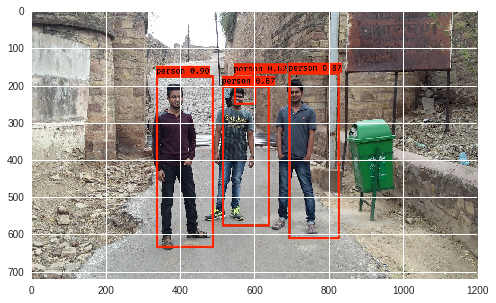

In [0]:
out_scores, out_boxes, out_classes = predict(sess, "image1.jpg")

Accuracy measurement is very significant for any model. But here, we have to consider 2 things: <b>classification</b> and <b>localization</b>. So, <b>mAP( Mean Average Precision)</b> is used to measure the accuracy for the object detected.
For AP(Average precision), first precision-recall curve is computed for the models detection output, by varying the model score threshold.

<img src="./images/img1.png" style="width:300px;height:300;"><caption><center>[Figure 1](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3)</center></caption>
Every class will have a single curve.


<i><b>Recall </b></i> is defined as the proportion of all positive examples ranked above a given probability_score (probability for an object to be present in the image).

<i><b>Precision </b></i>is the proportion of all examples above the rank which are from the positive class.


$$AP = \frac{1}{11}\sum_{r\in(0, 0.1, ..., 1)}P_{interp}(r)$$

$P_{interp}(r)$ is the interpolation r by taking the maximum precision measured for a method for which the corresponding recalll exceeds r. Interpolation reduces the wiggles in precision/recall curve.

This was for the classification task. For correlation we have to use IoU(Intersection over Union) threshold as for each particular class of object we plot the precision/recall curve with respect to every IoU threshold and take the mean of all.

<img src="./images/img2.png" style="width:300px;height:300;"><caption><center>[Figure 2](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3)</center></caption>

**References**: The ideas presented in this notebook came primarily from the YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. Also some of the idea in this notebook is from the angdrew_ng course on deep learning, coursera.

 - Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
 - Andrew_ng deep learning course - [Deep learning Specialization course](https://www.coursera.org/specializations/deep-learning)
 - The official YOLO website (https://pjreddie.com/darknet/yolo/) 
 - Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
 - Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
 - Timothy C Arlen - [Understanding the mAP Evaluation Metric for Object Detection](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3)